In [115]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [116]:
def feature_detection(img1, img2):
    my_SIFT_instance = cv2.SIFT_create()
    ref_keypoints, ref_descriptors = my_SIFT_instance.detectAndCompute(img1, None) # returns list of keypoints and an array of 128xkp
    target_keypoints, target_descriptors = my_SIFT_instance.detectAndCompute(img2, None) # setting mask field to None
    img_1 = cv2.drawKeypoints(img1, ref_keypoints, img1)
    img_2 = cv2.drawKeypoints(img2, target_keypoints, img2)
    bf_matcher = cv2.BFMatcher()  # returns the best match
    matches = bf_matcher.knnMatch(ref_descriptors, target_descriptors, k=2)  # returns the k best matches
    # Using Lowe's Ratio Test to evaluate if the euclidean distance of one match is less than distance to next best match using threshold of 0.8
    good_match = []
    good_no_list = []
    for m, n in matches:
        if m.distance < 0.8*n.distance: # using each matches euclidean distance
            good_match.append([m]) # only considering the best matches
            good_no_list.append(m)
    lowes_matched_img = cv2.drawMatchesKnn(img_1, ref_keypoints, img_2, target_keypoints, good_match, flags=2, outImg = None)
    return lowes_matched_img, ref_keypoints, ref_descriptors, target_keypoints, target_descriptors, good_no_list

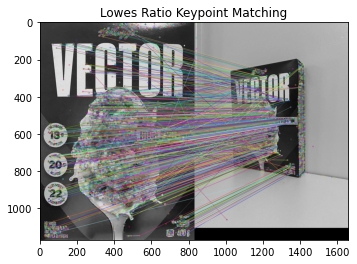

In [117]:
reference_img = cv2.cvtColor(cv2.imread("cereal.jpg"), cv2.COLOR_RGB2GRAY)
target_img = cv2.cvtColor(cv2.imread("cereal_r.jpg"), cv2.COLOR_BGR2GRAY)
reference_cpy = reference_img.copy()
target_cpy = target_img.copy()

lowes_matched_cereal, ref_pts, kp1, tar_pts, kp2, list_m = feature_detection(reference_cpy, target_cpy)
plt.title("Lowes Ratio Keypoint Matching")
plt.imshow(lowes_matched_cereal)

In [118]:
def create_target_img(r_img, img_h, img_w):
    # Find center coord of ref img
    c_x = img_width/2
    c_y = img_height/2
    # define rotation/scaling values
    rotation = 12
    scale = .5
    # retreive rotation matrix for img using cv2.getRotationMatrix2D()
    M = cv2.getRotationMatrix2D((c_x,c_y), rotation, scale)
    # use cv2.warpAffine() to retrieve the target image
    destination = cv2.warpAffine(r_img, M, (img_w, img_h))
    return destination

In [119]:
def affine_transform(r_img, t_img, img_width, img_height):
    c_x = img_width/2
    c_y = img_height/2
    # define rotation/scaling values
    rotation = 12
    scale = .5
    # retreive rotation matrix for img using cv2.getRotationMatrix2D()
    M = cv2.getRotationMatrix2D((c_x,c_y), rotation, scale)
    # use cv2.warpAffine() to retrieve the target image
    destination = cv2.warpAffine(r_img, M, (img_width, img_height))
    # retrieve kp/desc/Lowe's Ratio Matches
    lowes_matched_cereal, kp1, des_1, kp2, des_2, list_m = feature_detection(r_img, t_img)
    # format points for Opencv Transformation matrix
    src_pt = np.float32([kp1[i.queryIdx].pt for i in list_m]).reshape(-1, 1,2)
    dst_pt = np.float32([kp2[i.trainIdx].pt for i in list_m]).reshape(-1, 1,2)
    # retrieve the affine trasnformation matrix
    M, _ = cv2.estimateAffinePartial2D(src_pt, dst_pt)
    affine_transform_img = cv2.warpAffine(destination, M, (img_width, img_height))
    return affine_transform_img

In [120]:
reference_cpy2 = reference_img.copy()
img_width, img_height = reference_cpy2.shape
a_t_img = affine_transform(reference_cpy2, reference_cpy2, img_width, img_height)
cv2.imshow("Target Image", a_t_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [121]:
reference_image = cv2.imread("cereal.jpg")
img_width, img_height, _ = reference_image.shape
a_t_img = affine_transform(reference_image, reference_image, img_width, img_height)
cv2.imshow("Target Image", a_t_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [195]:
def perspective_transform(ref_g_img, tar_img, img_w, img_h):
    lowes_matched_cereal, kp1, des_1, kp2, des_2, list_m = feature_detection(ref_g_img, tar_img)
    # format points for Opencv Transformation matrix
    src_pt = np.float32([kp1[i.queryIdx].pt for i in list_m]).reshape(-1, 1,2)
    dst_pt = np.float32([kp2[i.trainIdx].pt for i in list_m]).reshape(-1, 1,2)
    # replacing steps 5/6
    M, _ = cv2.findHomography(src_pt, dst_pt, cv2.RANSAC, 5.0)
    img_height, img_width, _ = ref_g_img.shape
    dst = cv2.warpPerspective(ref_g_img, M, (img_width, img_height))
    return dst

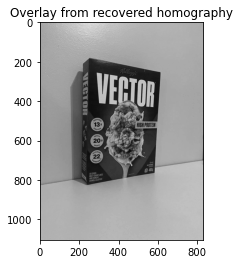

In [196]:
reference_image = cv2.cvtColor(cv2.imread("cereal.jpg"), cv2.COLOR_BGR2RGB)
r_img = reference_image.copy()
target_image = cv2.imread("cereal_l.jpg")
target_image_gray = cv2.cvtColor(cv2.imread("cereal_l.jpg"), cv2.COLOR_RGB2GRAY)

plt.title("Overlay from recovered homography")
plt.imshow(target_image_gray, cmap='gray')

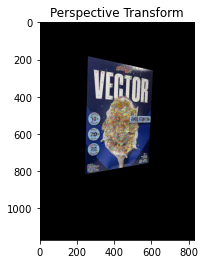

In [203]:
img_height, img_width, _ = reference_image.shape
pt_img = perspective_transform(r_img, target_image_gray, img_width, img_height)
plt.title("Perspective Transform")
plt.imshow(pt_img)

In [201]:
def overlay(og_img, ov_img):
    h, w = og_img.shape
    img = np.zeros((1104,828,3), np.uint8)
    for i in range(h):
        for j in range(w):
            if ov_img[i][j].all() == 0:
                img[i][j] = og_img[i][j]
            else:
                img[i][j] = ov_img[i][j]
    return img

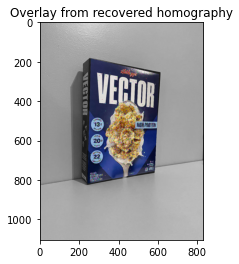

In [202]:
img = overlay(target_image_gray, a_t_img)

plt.title("Overlay from recovered homography")
plt.imshow(img)

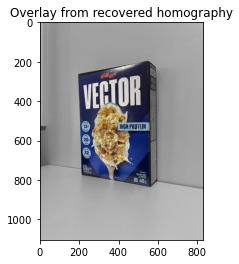

In [205]:
reference_image = cv2.cvtColor(cv2.imread("cereal.jpg"), cv2.COLOR_BGR2RGB)
r_img = reference_image.copy()
target_image = cv2.imread("cereal_r.jpg")
target_image_gray = cv2.cvtColor(cv2.imread("cereal_r.jpg"), cv2.COLOR_RGB2GRAY)
img_height, img_width, _ = reference_image.shape
pt_img = perspective_transform(r_img, target_image_gray, img_width, img_height)

img = overlay(target_image_gray, pt_img)

plt.title("Overlay from recovered homography")
plt.imshow(img)

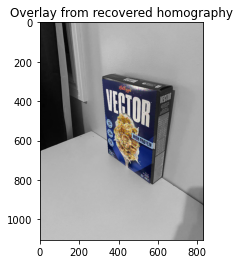

In [206]:
reference_image = cv2.cvtColor(cv2.imread("cereal.jpg"), cv2.COLOR_BGR2RGB)
r_img = reference_image.copy()
target_image = cv2.imread("cereal_tr.jpg")
target_image_gray = cv2.cvtColor(cv2.imread("cereal_tr.jpg"), cv2.COLOR_RGB2GRAY)
img_height, img_width, _ = reference_image.shape
pt_img = perspective_transform(r_img, target_image_gray, img_width, img_height)

img = overlay(target_image_gray, pt_img)

plt.title("Overlay from recovered homography")
plt.imshow(img)

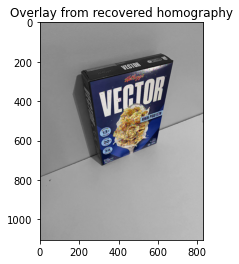

In [207]:
reference_image = cv2.cvtColor(cv2.imread("cereal.jpg"), cv2.COLOR_BGR2RGB)
r_img = reference_image.copy()
target_image = cv2.imread("cereal_tl.jpg")
target_image_gray = cv2.cvtColor(cv2.imread("cereal_tl.jpg"), cv2.COLOR_RGB2GRAY)
img_height, img_width, _ = reference_image.shape
pt_img = perspective_transform(r_img, target_image_gray, img_width, img_height)

img = overlay(target_image_gray, pt_img)

plt.title("Overlay from recovered homography")
plt.imshow(img)